In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr,spearmanr
import itertools
from sklearn.cross_decomposition import CCA
import networkx as nx
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
patient_col = 'Donor'
nb, cn = 10, 5
neigh_col = f'neighborhood{cn}'
group_patients = {'ND': ['ABI2259', 'ACHM315', 'AFES372', 'AFFN281', 'AFG1440', 'AGBA390'],
                  'T2D': ['ABHQ115', 'ABIC495', 'ABIQ254', 'ACIA085', 'ADBI307', 'ADIX484', 'ADLE098', 'AEDN413', 'AEJR177', 'AFCM451']}
# group_patients = {'ND': ['ABHQ115_0', 'ABIC495_0', 'ABIQ254_0', 'ACIA085_0', 'ADBI307_0', 'ADIX484_0', 'AEDN413_0', 'AEJR177_0', 'AFCM451_0'],
#                   'T2D': ['ABIC495_1', 'ABIQ254_1', 'ADBI307_1', 'ADIX484_1', 'ADLE098_1', 'AEJR177_1', 'AFCM451_1']}
good_patients = group_patients['ND'] + group_patients['T2D']

In [16]:
cells2 = pd.read_csv(f'cleaned_cell_{nb}_normalized_cosine_key5.csv')
all_frqs = pd.read_csv(f'allcell_type_counts_perneighborhood_perpatient_nb{nb}_cn{cn}_normalized_cosine_key5.csv')

In [17]:
#work out neighborhood counts
nbd_counts = cells2.groupby([patient_col, neigh_col]).size().unstack().fillna(0).loc[good_patients]
pat_counts = cells2.groupby([patient_col]).size().fillna(0).loc[good_patients]

In [25]:
# select which neighborhoods and functional subsets
nbs = [i for i in range(cn)]

# chks = ['Helper T cell', 'Cytotoxic T cell', 'Inactive T cell', 'Other T cell']
# chks = ['M1 mac', 'M2 mac', 'M1/M2 mac', 'Other mac']
# chks = ['HLA-DR+ EC', 'CD34+ EC', 'HLA-DR+ CD34+ EC', 'Other EC']
# chks = ['α cell', 'δ cell', 'β cell', 'γ cell', 'ɛ cell', 'Helper T cell', 'Cytotoxic T cell', 'Inactive T cell', 'Other T cell',
#         'M1 mac', 'M2 mac', 'M1/M2 mac', 'Other mac', 'Other immune cell', 'HLA-DR+ EC', 'CD34+ EC', 'HLA-DR+ CD34+ EC', 'Other EC',
#         'Pericyte', 'Other cell']
chks = ['α cell', 'δ cell', 'β cell', 'γ cell']

In [26]:
# make a df of neighborhood specific cell type densities
x = all_frqs.reset_index().iloc[:,1:]
for patient in good_patients:
    for i in range(cn):
        if len(x[(x[patient_col] == patient) & (x[neigh_col] == i)]) == 0:
            x = x.append({patient_col: patient, neigh_col: i}, ignore_index=True)

df_list = []
for nb in nbs:
    arr = x.loc[x[neigh_col]==nb,:].set_index(patient_col).loc[good_patients,chks].values
    arr /= nbd_counts[nb].values[:,None]
    df_list.append(pd.DataFrame(arr, index = good_patients, columns = [chk+'_'+str(nb) for chk in chks]))
    
X_density = pd.concat(df_list, axis = 1)
X_density.fillna(value=0, inplace=True) # added

X_density = np.log(1e-3+X_density.loc[:, X_density.apply(np.std,axis = 0)>0])
# X_density = np.log(1e-3+X_density)

In [27]:
cca = CCA(n_components=1,max_iter = 1000)
def do_cca( n_perms,fun = 'pearson'):
    if fun == 'pearson':
        func = pearsonr
    if fun == 'spearman':
        func = spearmanr
    
    cols = [chk + '_' for chk in chks]
    stats = {}
    for gp in ['ND', 'T2D']:
        stats[gp] = {}
        for k,nb1 in enumerate(nbs):
            for l,nb2 in enumerate(nbs):
                if (k<l):
                    nb1_cols = [c +str(nb1) for c in cols]
                    nb2_cols = [c +str(nb2) for c in cols]
                    dat = X_density.loc[group_patients[gp],nb1_cols+nb2_cols].dropna(axis = 1, how = 'all').dropna(axis = 0, how = 'any')
                    
                    a = dat.loc[:,[n for n in nb1_cols if n in dat.columns]].values
                    b = dat.loc[:,[n for n in nb2_cols if n in dat.columns]].values
                    if (len(a)<2) or (a.shape[1]<1) or (b.shape[1]<1):
                        print('continuing',nb1,nb2)
                        continue

    
                    x,y = cca.fit_transform(a,b)
                    arr = np.zeros(n_perms)
                    #compute the canonical correlation
                    stats[gp][nb1,nb2] = (func(x.squeeze(),y.squeeze())[0],arr)
                    for i in range(n_perms):
                        idx = np.arange(len(a))
                        np.random.shuffle(idx)
                        #compute over n_perms permutations
                        xt,yt = cca.fit_transform(a[idx],b)
                        arr[i] = func(xt.squeeze(),yt.squeeze())[0]
        print(gp, 'done')


    return stats

In [28]:
np.random.seed(145)
stats = do_cca( n_perms = 5000,fun = 'pearson')

ND done
T2D done


In [29]:
def draw_stats(stats_treg,cutoff = 0.1):
    g1 = nx.Graph()
    g2 = nx.Graph()
    for k,nb1 in enumerate(nbs):
        for l,nb2 in enumerate(nbs):
            if (k<l):
                p1 = np.mean(stats_treg['ND'][(nb1,nb2)][1]<stats_treg['ND'][(nb1,nb2)][0])
                p2 = np.mean(stats_treg['T2D'][(nb1,nb2)][1]<stats_treg['T2D'][(nb1,nb2)][0])
                if (1-p1)<cutoff:
                    g1.add_edge(nb1,nb2,weight = 1-p1)
                    print('gp1',nb1,nb2,p1,p2)
                if (1-p2)<cutoff:
                    g2.add_edge(nb1,nb2,weight = 1-p2)
                    print('gp2',nb1,nb2,p1,p2)

    for i in nbs:
        g1.add_node(i)
        g2.add_node(i)

    nx.draw_networkx(g1) 
    plt.axis('off')
    plt.show()

    nx.draw_networkx(g2)
    plt.axis('off')
    plt.show()
    return g1,g2

gp1 0 4 0.9698 0.9034
gp2 0 4 0.9698 0.9034
gp2 1 3 0.1034 0.9566
gp2 2 4 0.3636 0.9828


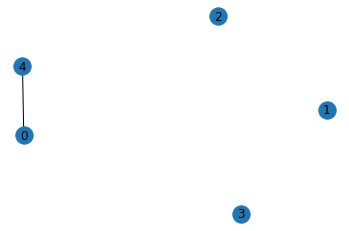

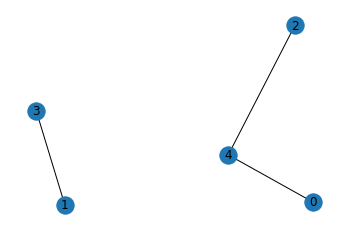

In [30]:
g1, g2 = draw_stats(stats)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

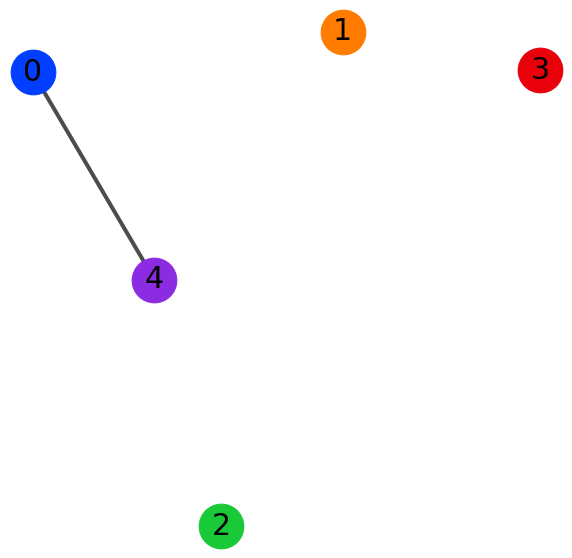

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

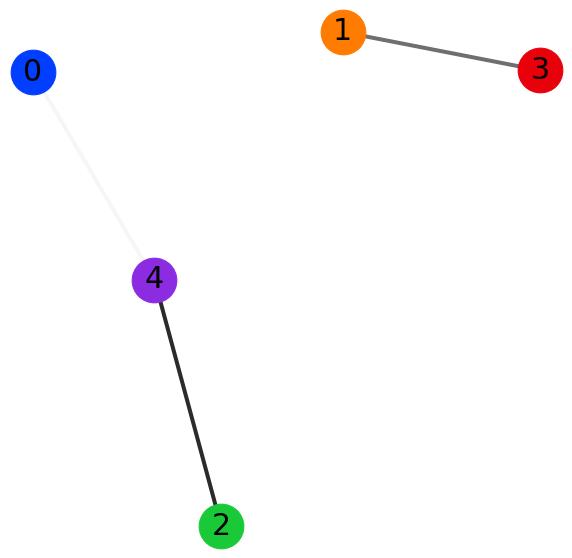

In [33]:
pal = sns.color_palette('bright',10)
dash = {True: '-', False: ':'}
# pos=nx.drawing.nx_pydot.pydot_layout(g1,prog='neato')
g_comb = g1.copy()
for source,dest in g2.edges:
    g_comb.add_edge(source,dest)
pos=nx.drawing.nx_pydot.pydot_layout(g_comb,prog='neato')
for k,v in pos.items():
    x,y = v
    plt.scatter([x],[y],c = pal[k], s = 2000,zorder = 3)
    plt.text(x,y, k, fontsize = 30, zorder = 10,ha = 'center', va = 'center')


atrs = nx.get_edge_attributes(g1, 'weight')    
for e0,e1 in g1.edges():
    p = atrs[e0,e1]
    plt.plot([pos[e0][0],pos[e1][0]],[pos[e0][1],pos[e1][1]], c= 'black',alpha = 1-10*p,linewidth = 4)
    #plt.text(0.5*(pos[e0][0]+pos[e1][0]),0.5*(pos[e0][1]+pos[e1][1]), 'p = %.3f'%p)
    
plt.axis('off')

plt.savefig('raw_figs/cn_markups_v1/nb10_cn5_normalized_cosine_key5/networks/network_%s_ND.jpg' % '_'.join(chks))
plt.show()

figsize(10,10)
## pos=nx.drawing.nx_pydot.pydot_layout(g2,prog='neato')
for k,v in pos.items():
    x,y = v
    plt.scatter([x],[y],c = pal[k], s = 2000,zorder = 3)
    plt.text(x,y, k, fontsize = 30, zorder = 10,ha = 'center', va = 'center')
atrs = nx.get_edge_attributes(g2, 'weight')    
for e0,e1 in g2.edges():
    p = atrs[e0,e1]
    plt.plot([pos[e0][0],pos[e1][0]],[pos[e0][1],pos[e1][1]], c= 'black',alpha = 1-10*p,linewidth = 4)
    #plt.text(0.5*(pos[e0][0]+pos[e1][0]),0.5*(pos[e0][1]+pos[e1][1]), 'p = %.3f'%p)
#plt.ylim(-100,350)
plt.axis('off')
plt.savefig('raw_figs/cn_markups_v1/nb10_cn5_normalized_cosine_key5/networks/network_%s_T2D.jpg' % '_'.join(chks))
    
plt.show()

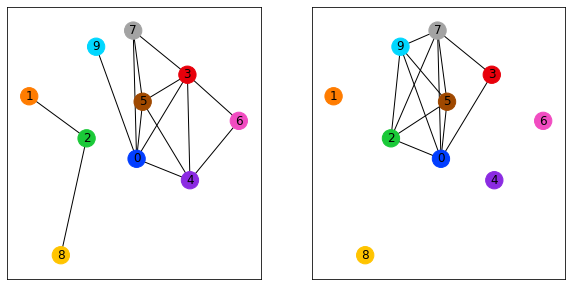

In [54]:
# to make graph with common node postiions  (in final paper, we use node positions of g1 however)
g_comb = g1.copy()
for source,dest in g2.edges:
    g_comb.add_edge(source,dest)
    
pos = nx.drawing.nx_pydot.graphviz_layout(g_comb,'neato')
f,ax = plt.subplots(ncols = 2,sharex=True,sharey=True,figsize = (10,5))
#g1.add_node(9)
nx.draw_networkx(g1,pos = pos,ax = ax[0],node_color=[sns.color_palette('bright')[i] for i in g1.nodes])

#g2.add_node(5)
nx.draw_networkx(g2,pos = pos,ax = ax[1],node_color=[sns.color_palette('bright')[i] for i in g2.nodes])